In [2]:
from transformers import AutoTokenizer
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np
from tqdm import tqdm

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
model_name = "HiTZ/latxa-7b-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
ds_euscrawl = load_dataset("HiTZ/latxa-corpus-v1.1", 'euscrawl-v1.1')

In [6]:
# Vocabulary size
print("Vocabulary size:", tokenizer.vocab_size)

Vocabulary size: 32000


In [7]:
# Save vocabulary to TSV file

vocab = tokenizer.get_vocab()  # dict: token -> id
print(f"Vocabulary loaded, {len(vocab)} tokens found.")
vocab_sorted = sorted(vocab.items(), key=lambda x: x[1])
OUTPUT_FILE = "../data/latxa-7b-v1.1-vocab.tsv"

with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
    f.write("token\tid\n")
    for token, idx in vocab_sorted:
        f.write(f"{token}\t{idx}\n")

print(f"Vocabulary saved to {OUTPUT_FILE}")

Vocabulary loaded, 32000 tokens found.
Vocabulary saved to ../data/latxa-7b-v1.1-vocab.tsv


In [8]:
text = "Euskara adimen arttifizialera iritsi da!"

# Encode text → token IDs
token_ids = tokenizer.encode(text)
print("Token IDs:", token_ids)

# Decode back to text
decoded_text = tokenizer.decode(token_ids)
print("Decoded text:", decoded_text)

Token IDs: [1, 382, 17400, 2518, 594, 19933, 564, 698, 21722, 616, 1572, 3805, 277, 1039, 1146, 29991]
Decoded text: <s> Euskara adimen arttifizialera iritsi da!


BASIC TOKENIZATION STATISTICS

In [5]:
# Average tokens per word and per sentence

def avg_tokens_per_word(sentences):
    token_counts = []
    word_counts = []

    for sent in sentences:
        tokens = tokenizer.tokenize(sent)
        words = sent.split()

        token_counts.append(len(tokens))
        word_counts.append(len(words))

    avg_tokens_word = sum(token_counts) / sum(word_counts)
    avg_tokens_sentence = sum(token_counts) / len(sentences)

    return avg_tokens_word, avg_tokens_sentence

sentences = ds_euscrawl['train']['text'][:50000]
avg_tokens_word, avg_tokens_sentence = avg_tokens_per_word(sentences)
print(f"Average tokens per word: {avg_tokens_word:.2f}")
print(f"Average tokens per sentence: {avg_tokens_sentence:.2f}")

Average tokens per word: 3.19
Average tokens per sentence: 650.62


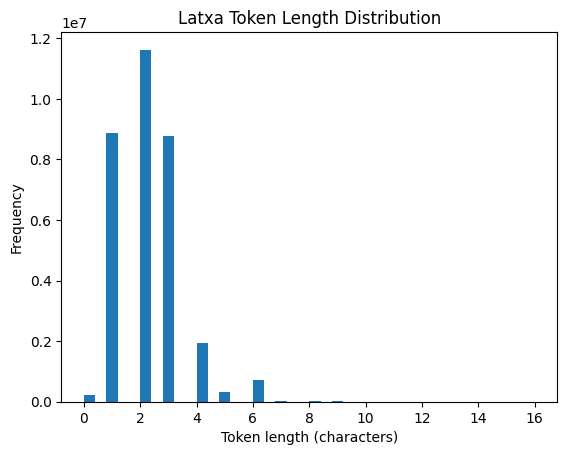

In [ ]:
# Token length distribution

all_tokens = []
for sent in sentences:
    t = tokenizer.tokenize(sent)
    all_tokens.extend(t)

# compute token lengths
token_lengths = [len(tok.replace("▁", "")) for tok in all_tokens]

plt.hist(token_lengths, bins=40)
plt.xlabel("Token length (characters)")
plt.ylabel("Frequency")
plt.title("Latxa Token Length Distribution")
plt.show()

In [ ]:
# Word coverage analysis

def word_coverage(tokenizer, sentences, max_check=30000):    
    total = 0
    single = 0
    for sent in sentences[:max_check]:
        words = sent.split()
        for w in words:
            ids = tokenizer.encode(w, add_special_tokens=False)
            ids = [i for i in ids if i not in tokenizer.all_special_ids]
            total += 1
            if len(ids) == 1:
                single += 1

    return {
        "total": total,
        "single": single
    }

wc = word_coverage(tokenizer, sentences)
print(wc)

{'total': 6040519, 'single': 458390}


In [21]:
print(f"Single-token word coverage: {wc['single']}/{wc['total']} ({(wc['single']/wc['total'])*100:.2f}%)")

Single-token word coverage: 458390/6040519 (7.59%)


In [12]:
# Most common subwords

subword_counts = Counter()

for sent in sentences:
    tokens = tokenizer.tokenize(sent)
    subword_counts.update(tokens)

# show most common subwords
for token, count in subword_counts.most_common(30):
    print(f"{token}: {count}")

a: 925826
,: 897237
.: 685129
an: 678140
<0x0A>: 622992
ak: 532591
▁et: 441600
ko: 440448
en: 390349
▁b: 322206
▁d: 320535
u: 312059
k: 301472
z: 287452
o: 287225
▁z: 279848
ik: 272644
ako: 270351
ar: 263712
at: 239945
▁: 229734
0: 212259
et: 198610
▁g: 196192
▁e: 192771
i: 186542
ze: 181178
▁du: 180060
ra: 178761
▁da: 177968


SPECIAL TOKENS

In [31]:
# Special tokens (e.g., padding, unknown, BOS, EOS)
print("Special tokens:", tokenizer.special_tokens_map)

# Example: IDs of special tokens
print("Special token IDs:", {k: tokenizer.convert_tokens_to_ids(v) 
                             for k,v in tokenizer.special_tokens_map.items()})


Special tokens: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}
Special token IDs: {'bos_token': 1, 'eos_token': 2, 'unk_token': 0}


In [48]:
def analyze_special_tokens(tokenizer, texts, max_texts=20000):
    special = set(tokenizer.all_special_ids)
    token_counter = Counter()
    total_tokens = 0

    for text in tqdm(texts[:max_texts]):
        encoding = tokenizer(text, add_special_tokens=True)
        ids = encoding["input_ids"]
        
        total_tokens += len(ids)
        token_counter.update(ids)

    special_counts = {
        tokenizer.convert_ids_to_tokens(tid): token_counter[tid]
        for tid in tokenizer.all_special_ids
    }
    return {
        "special_token_counts": special_counts,
        "total_tokens": total_tokens
    }

sentences_test = ds_euscrawl['test']['text'][:20000]
results = analyze_special_tokens(tokenizer, sentences_test)
print("Special token counts:", results["special_token_counts"])
print("Total tokens analyzed:", results["total_tokens"])


100%|██████████| 17736/17736 [00:10<00:00, 1760.54it/s]

Special token counts: {'<s>': 17736, '</s>': 0, '<unk>': 0}
Total tokens analyzed: 11284287


Latxa’s tokenizer:
- is extremely subword-heavy
- rarely encodes whole Basque words as a single token (7.59%)
- but it still uses valid subwords → "unk" is never needed

TOKENIZATION CONSISTENCY

In [55]:
families = {
    "etxe (house)": ["etxe", "etxea", "etxeak", "etxeko", "etxeetako", "etxearen",
                    "etxeen", "etxean","etxeetan", "etxetik", "etxeetatik", "etxera",
                    "etxeetara", "etxerantz", "etxeetarantz"],
    "eskola (school)": ["eskola", "eskolak", "eskolako", "eskoletako", "eskolaren",
                       "eskolen", "eskolan", "eskoletan", "eskolatik", "eskoletatik",
                       "eskolara", "eskoletara", "eskolarantz", "eskoletarantz"],
    "neska (girl)": ["neska", "neskak", "neskek", "neskaren", "nesken", "neskari",
                     "neskei", "neskarekin", "neskekin", "neskarengana", "neskengana"],
    "ume (kid)": ["ume", "umea", "umeak", "umeek", "umearen", "umeen", "umeari", 
                  "umeei", "umearekin", "umeekin", "umearengana", "umeengana"],
    "osasun (health)": ["osasun-zerbitzu", "osasun-sistema", 
                        "osasun-politika", "osasun-langile", "osasun-zentro", 
                        "osasun-etxe", "osasun-krisi", "osasun-arazo"]
}

def analyze_family(words):
    print("\n=== Morphological Family ===")
    for w in words:
        tokens = tokenizer.tokenize(w)
        print(f"{w:<15} → {tokens}")

for family, words in families.items():
    print(f"\n############################")
    print(f"### {family}")
    print("############################")
    analyze_family(words)



############################
### etxe (house)
############################

=== Morphological Family ===
etxe            → ['▁et', 'xe']
etxea           → ['▁et', 'x', 'ea']
etxeak          → ['▁et', 'xe', 'ak']
etxeko          → ['▁et', 'x', 'ek', 'o']
etxeetako       → ['▁et', 'xe', 'et', 'ako']
etxearen        → ['▁et', 'x', 'ear', 'en']
etxeen          → ['▁et', 'xe', 'en']
etxean          → ['▁et', 'xe', 'an']
etxeetan        → ['▁et', 'xe', 'et', 'an']
etxetik         → ['▁et', 'x', 'et', 'ik']
etxeetatik      → ['▁et', 'xe', 'et', 'at', 'ik']
etxera          → ['▁et', 'x', 'era']
etxeetara       → ['▁et', 'xe', 'et', 'ara']
etxerantz       → ['▁et', 'x', 'er', 'ant', 'z']
etxeetarantz    → ['▁et', 'xe', 'et', 'ar', 'ant', 'z']

############################
### eskola (school)
############################

=== Morphological Family ===
eskola          → ['▁es', 'k', 'ola']
eskolak         → ['▁es', 'kol', 'ak']
eskolako        → ['▁es', 'kol', 'ako']
eskoletako      → ['▁es', 'ko

What we can observe:
1. Stem inconsistency: all four stem words are split differently depending on the suffix they have attached.
2. Suffix inconsistency: suffixes like -ko (from where), -ren (whose), -ri (to who) are not split consistently.
3. Compound words: compound words in Basque are often hyphenated, and the splitting in this case is quite consistent.

Average Rank

100%|██████████| 50000/50000 [00:38<00:00, 1286.02it/s]


Total tokens analyzed: 32530950
Average Rank: 8693.781218070792
Median Rank: 1997.0

Percentiles:
10th percentile: 285.0
25th percentile: 446.0
50th percentile: 1997.0
75th percentile: 14737.0
90th percentile: 29889.0
95th percentile: 29900.0


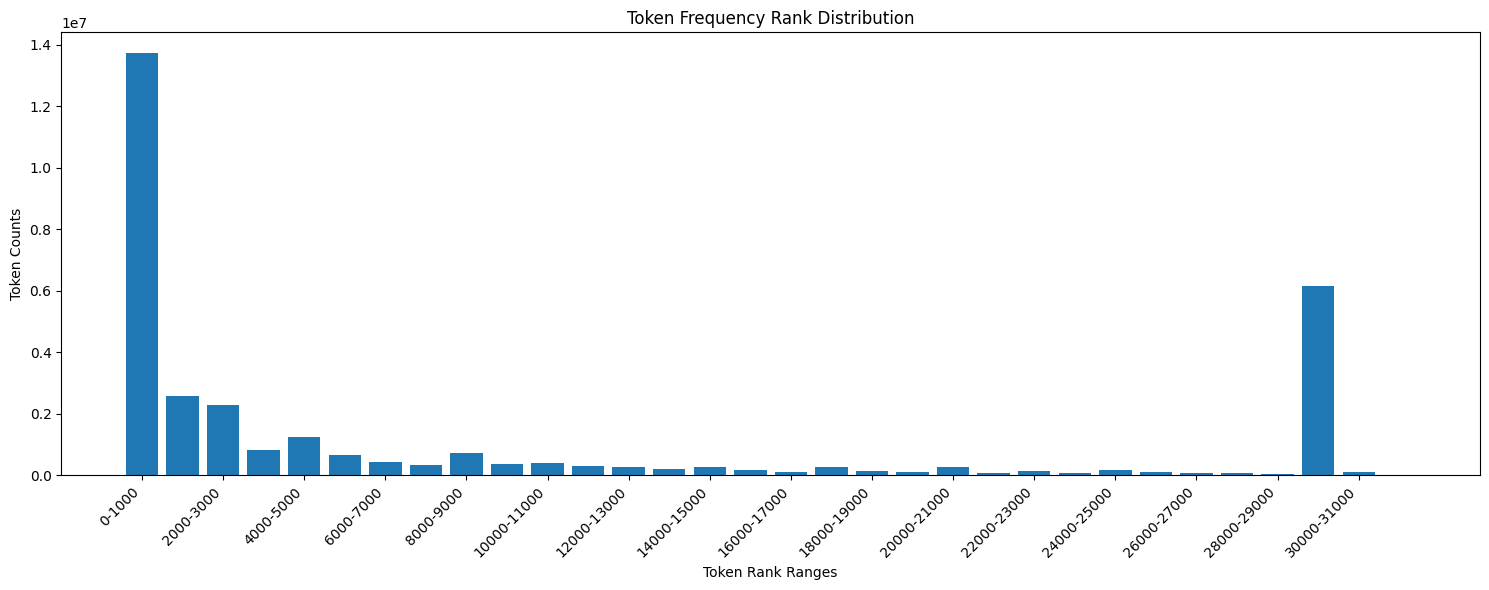

In [10]:
# Token frequency rank analysis

token_to_rank = {tok: idx for tok, idx in tokenizer.get_vocab().items()} 

ranks = []
for line in tqdm(sentences):
    token_ids = tokenizer.encode(line, add_special_tokens=False)
    for tid in token_ids:
        tok = tokenizer.convert_ids_to_tokens(tid)
        if tok in token_to_rank:
            ranks.append(token_to_rank[tok])
ranks = np.array(ranks)

print("Total tokens analyzed:", len(ranks))
print("Average Rank:", ranks.mean())
print("Median Rank:", np.median(ranks))
print("\nPercentiles:")
for p in [10, 25, 50, 75, 90, 95]:
    print(f"{p}th percentile:", np.percentile(ranks, p))


bins = list(range(0, 32001, 1000))
hist = np.histogram(ranks, bins=bins)

# Create bar plot
plt.figure(figsize=(15,6))  # make it wider
plt.bar(range(len(hist[0])), hist[0])

# Use tick labels for every 2nd or 5th bin
tick_positions = range(0, len(bins)-1, 2)  # change 2 → 5 if too crowded
tick_labels = [f"{b1}-{b2}" for b1, b2 in zip(bins[:-1], bins[1:])]
plt.xticks(tick_positions, [tick_labels[i] for i in tick_positions], rotation=45, ha='right')

plt.xlabel("Token Rank Ranges")
plt.ylabel("Token Counts")
plt.title("Token Frequency Rank Distribution")
plt.tight_layout()  # prevent cutting off labels
plt.show()

In [9]:
# Get all subwords in the vocabulary
vocab = list(tokenizer.get_vocab().keys())

# Typical Basque patterns
basque_patterns = [
    r"tx", r"tz", r"ts", r"dd", r"tt", r"rr", r"k$", r"n$", r"ko$", r"ren$", r"etan$"
]

# Typical English patterns
english_patterns = [
    r"ing$", r"tion$", r"th", r"sh", r"ch", r"ck", r"ed$", r"ly$", r"pre", r"com", r"un", r"re", r"w", r"c", r"tch", r"wr", r"with", r"y"
]

def classify_token(token):
    is_basque = any(re.search(p, token) for p in basque_patterns)
    is_english = any(re.search(p, token) for p in english_patterns)
    return is_basque, is_english

basque_tokens = []
english_tokens = []
shared = []
other = []

for tok in vocab:
    is_basque, is_english = classify_token(tok)
    if is_basque and is_english:
        shared.append(tok)
    elif is_basque:
        basque_tokens.append(tok)
    elif is_english:
        english_tokens.append(tok)
    else:
        other.append(tok)

print("Total vocab size:", len(vocab))
print("Basque-like subwords:", len(basque_tokens))
print("English-like subwords:", len(english_tokens))
print("Shared Basque+English patterns:", len(shared))
print("Other / Neutral subwords:", len(other))

# show examples
print("\n### Example Basque-like subwords")
print(basque_tokens[:40])

print("\n### Example English-like subwords")
print(english_tokens[:40])

print("\n### Example shared-pattern subwords")
print(shared[:40])


Total vocab size: 32000
Basque-like subwords: 2057
English-like subwords: 8137
Shared Basque+English patterns: 1347
Other / Neutral subwords: 20459

### Example Basque-like subwords
['▁formatt', 'oken', '▁doesn', 'lets', '▁månaden', '▁tierra', 'iten', 'San', '▁genomsnitt', 'HttpRequest', '▁Json', 'aison', 'uttavia', '▁Span', '▁on', '▁opts', '▁Ren', '▁Mark', 'znik', '▁seizoen', 'ijn', '▁Regin', '▁erhalten', 'button', '▁blank', 'ampion', '▁kon', 'admin', 'An', '▁elimin', '▁Moon', '▁können', 'Origin', '▁btn', '▁León', '▁lists', '▁kön', '▁spirits', 'ellett', 'ordon']

### Example English-like subwords
['▁window', '▁wrześ', 'project', '▁Kennedy', '▁Moreover', 'Cred', '▁Jacques', 'layer', '▁contains', '▁recall', '▁greatest', 'iere', '▁tradicional', 'cons', 'othy', 'skich', '▁deprec', '▁municipality', '▁Place', '▁Przypisy', 'fully', '▁resource', '▁electronic', 'atic', '▁inicial', '▁Bowl', '▁matches', '▁Beach', '▁frequ', '▁Greece', 'reiche', 'etry', '▁CGRect', 'junit', '▁reliable', '▁duty', 'y